In [105]:
import math
import datetime
from matplotlib import pyplot as plt
from FinMind.Data import Load
import numpy as np
import json
import pandas as pd
TaiwanStockInfo = Load.FinData(dataset = 'TaiwanStockInfo')
  

stock_id=1101
some_days_ago=700

data = Load.FinData(dataset = 'TaiwanStockPrice',select = [str(stock_id)],date = str(datetime.date.today()-datetime.timedelta(days = some_days_ago)))

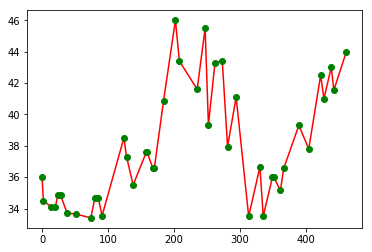

In [106]:
#####
def make_line(data,rolling_num=20):
#     data['close'].plot(figsize=(16,9))
    #center 和 min_periods很重要
    data['rmax']=data['close'].rolling(rolling_num,min_periods=1,center=True).max()
    data['rmin']=data['close'].rolling(rolling_num,center=True,min_periods=1).min()   
    data['local_max_or_not']=data['rmax']==data['close']
    data['local_min_or_not']=data['rmin']==data['close']
    #找到重要的直
    data['critical']=np.logical_or(data['local_max_or_not'],data['local_min_or_not'])
#     畫圖
    plt.plot(data['close'][data['critical']],'r-')
    plt.plot(data['close'][data['critical']],'go')
    return data
result=make_line(data)
plt.show()

In [107]:
#功能：判斷上升段 下降段
#有三種可能 上升 平 下降
critical_point_list=data['critical']
critical_price       =data[['close']][critical_point_list]
critical_price['index']= critical_price.index
critical_price['gap']=critical_price['close']-critical_price['close'].shift(1)
ans=map(lambda x:'up' if x>0  else 'down' if x<0 else 'flat' if x==0 else 'non',critical_price['gap'])
critical_price['type']=list(ans)
critical_price=critical_price[critical_price['type']!='flat']
critical_price['next_type']=critical_price['type'].shift(-1)
critical_price=critical_price[critical_price['next_type']!=critical_price['type']]
del critical_price['next_type']

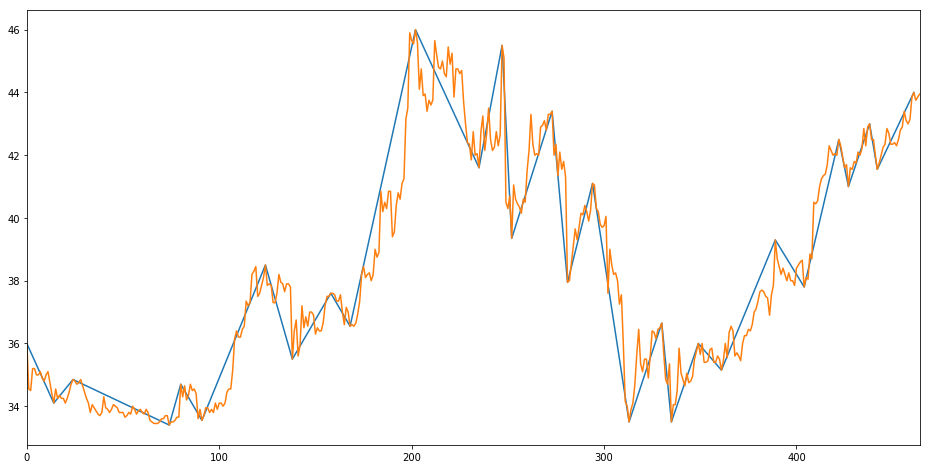

In [108]:
#測試畫完的圖
data.iloc[critical_price.index]['close'].plot()
data['close'].plot(figsize=(16,8))
plt.show()

In [109]:
essential_data=data.iloc[critical_price.index][['date','close']]
essential_data['next_close']=essential_data['close'].shift(-1)
essential_data['type']=critical_price['type'].shift(-1)
essential_data['mid_point']=(essential_data['close']+essential_data['close'].shift(-1))/2
essential_data['last_mid_point']=essential_data['mid_point'].shift(1)
essential_data['type1_buy']=np.logical_and(list(essential_data['type']=='down'),list(essential_data['next_close']> essential_data['last_mid_point']))
essential_data['type1_sell']=np.logical_and(list(essential_data['type']=='up'),list(essential_data['next_close']<essential_data['last_mid_point']))

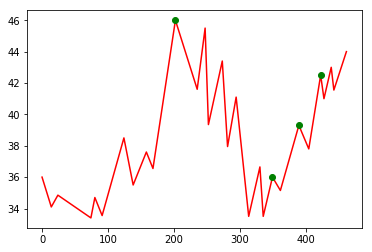

In [110]:
plt.plot(essential_data['close'],'r-')
plt.plot(essential_data['close'][essential_data['type1_buy']],'go')
plt.show()

In [111]:
essential_data[essential_data['type1_buy']]
#資料表的格式需要 第二波的起點(當作判斷是否能TYPE1的購買) 第一波的中間點(判斷是否波型破壞)=>essential data裡面都有這些東西
#STEP1 提取資料 接下來從INDEX +1開始進行判斷

,date,close,next_close,type,mid_point,last_mid_point,type1_buy,type1_sell
202,2018-05-21,46.0,41.60,down,43.800,41.275,True,False
349,2018-12-17,36.0,35.15,down,35.575,34.750,True,False
389,2019-02-21,39.3,37.80,down,38.550,37.225,True,False
422,2019-04-15,42.5,41.00,down,41.750,40.150,True,False


In [112]:
lose_list              = []
earn_list              = []
for i in essential_data[essential_data['type1_buy']].iterrows():
    start_index            = i[0]                       #起始日期的INDEX
    list_obj               = i[1]                       #上面那個表(essential_data)的一列
    now_index              = start_index                #開始迴圈時當前日期的index   
    start_point            = list_obj['close']          #第一波的最高點 當超過最高點時就啟動了
    wave_control_condition = list_obj['last_mid_point'] #第一波的中間點 當低於這個點波型破壞 
    first_wave_gap         = abs(start_point-wave_control_condition)*2
    purchase               = False
    purchase_price         = 0
    stop_loss_factor       = 20                         #跌超過20%就停損
    nfactor                = 1                          #漲超過第一波的n倍就停利
    
    #logic compute
    while(now_index<=(len(data)-1)):
        now_price    =data['close'][now_index]
        now_index+=1
        if(purchase):
                    if -now_price+purchase_price>purchase_price*(1-stop_loss_factor/100):
#                         print('賠太多 殺出')
                        lose_list.append([-now_price+purchase_price,now_price,start_index,now_index,first_wave_gap])
                        break

                    if now_price<wave_control_condition:
                        print('波破壞 退出 認賠')
                        losemoney=data['close'][start_index]-data['close'][now_index]
#                         print(losemoney)
                        lose_list.append([losemoney,now_price,start_index,now_index,first_wave_gap])
                        purchase         =False
                        break
                    elif (now_price-purchase_price)>first_wave_gap*nfactor:
#                         print('收手有賺錢 賺了',now_price-purchase_price,'現在價格',now_price)
                        purchase         =False
                        earn_list.append([now_price-purchase_price,now_price,start_index,now_index,first_wave_gap])
                        break
                
        elif(not purchase):
                    if now_price<wave_control_condition:
                        print('波破壞 退出')
                        break
                    elif now_price>wave_control_condition:
                        purchase       = True
                        purchase_price = now_price
                        #print('type1發動---購買價格',purchase_price,'第一波漲幅',first_wave_gap)

earn_list=pd.DataFrame(earn_list,columns=['賺了','當前價格','買入日','賣出日','波一漲幅'])
lose_list=pd.DataFrame(lose_list,columns=['賠了','當前價格','買入日','賣出日','波一漲幅'])
combine_list = pd.DataFrame()

波破壞 退出 認賠


In [113]:
earn_list

,賺了,當前價格,買入日,賣出日,波一漲幅
0,3.30,39.30,349,390,2.50
1,4.55,43.85,389,461,4.15


In [114]:
lose_list

,賠了,當前價格,買入日,賣出日,波一漲幅
0,5.7,40.5,202,250,9.45
